In [1]:
import sys, os
from pathlib import Path
candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
PROJECT_ROOT = None
for c in candidates:
    if (c / "src").exists():
        PROJECT_ROOT = c
        break
if PROJECT_ROOT is None:
    raise RuntimeError("No se encontró la carpeta 'src'.")
sys.path.insert(0, str(PROJECT_ROOT))
os.environ["PYTHONPATH"] = str(PROJECT_ROOT) + os.pathsep + os.environ.get("PYTHONPATH", "")
print("Project root:", PROJECT_ROOT)

Project root: c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject


In [2]:
import numpy as np
import pandas as pd
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from src.utils import p, read_csv, ensure_dirs, save_table
from src.preprocessing import build_preprocessing_pipeline
from src.evaluation import (
    group_metrics_df, group_metrics_intersection_df, sweep_group_thresholds
)
from src.visualization import (
    plot_fairness_bars, plot_fairness_disparity, plot_group_threshold_tradeoff
)

ensure_dirs()
DATA_RAW = p("data", "raw", "Titanic-Dataset.csv")
df = read_csv(DATA_RAW)

# target
target = [c for c in df.columns if c.lower()=="survived"][0]
y = df[target].astype(int).values

# split (mismo seed que modelado previo)
X = df.drop(columns=[target])
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# preproc y transform
preproc = build_preprocessing_pipeline(df)
preproc.fit(X_train_df.join(pd.Series(y_train, name=target)))
X_train = preproc.transform(X_train_df)
X_test  = preproc.transform(X_test_df)

# modelo base (misma elección que en 03_Modeling)
logreg = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg.fit(X_train, y_train)
proba_test = logreg.predict_proba(X_test)[:, 1]
THRESH = 0.525  # umbral de equilibrio (F1-máx) elegido
y_pred_test = (proba_test >= THRESH).astype(int)

# atributos sensibles / de comparación
sex = df.loc[X_test_df.index, "Sex"] if "Sex" in df.columns else None
pclass = df.loc[X_test_df.index, "Pclass"] if "Pclass" in df.columns else None

In [3]:
# Sexo
if sex is not None:
    sex_lab = sex.map({"male": "Hombres", "female": "Mujeres"}).fillna(sex.astype(str))
    df_sex = group_metrics_df(y_test, y_pred_test, proba_test, sex_lab, "Sexo")
else:
    df_sex = pd.DataFrame(columns=["Atributo","Grupo","TPR","FPR","Precision","Dem.Par.","N"])

# Pclass
if pclass is not None:
    mask_13 = pclass.isin([1, 3]).values
    y13, yhat13, p13 = y_test[mask_13], y_pred_test[mask_13], proba_test[mask_13]
    cls_lab = pclass[mask_13].map({1: "1ra Clase", 3: "3ra Clase"})
    df_cls = group_metrics_df(y13, yhat13, p13, cls_lab, "Pclass")
else:
    df_cls = pd.DataFrame(columns=["Atributo","Grupo","TPR","FPR","Precision","Dem.Par.","N"])

# Unimos sólo columnas solicitadas
tabla2 = pd.concat([df_sex, df_cls], ignore_index=True)[["Grupo","TPR","FPR","Precision","Dem.Par."]]
tabla2_rounded = tabla2.copy()
for c in ["TPR","FPR","Precision","Dem.Par."]:
    tabla2_rounded[c] = tabla2_rounded[c].round(2)

# Guardar y mostrar
path_tabla2 = save_table(tabla2_rounded, name="fairness_by_group", description="Métricas de fairness por grupo (test).")
display(tabla2_rounded)

,Grupo,TPR,FPR,Precision,Dem.Par.
0,Hombres,0.37,0.03,0.75,0.10
1,Mujeres,1.00,0.50,0.85,0.87
2,3ra Clase,0.71,0.08,0.74,0.23
3,1ra Clase,0.76,0.20,0.83,0.51


c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=45, ha="right")
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=45, ha="right")
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=45, ha="right")
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_x

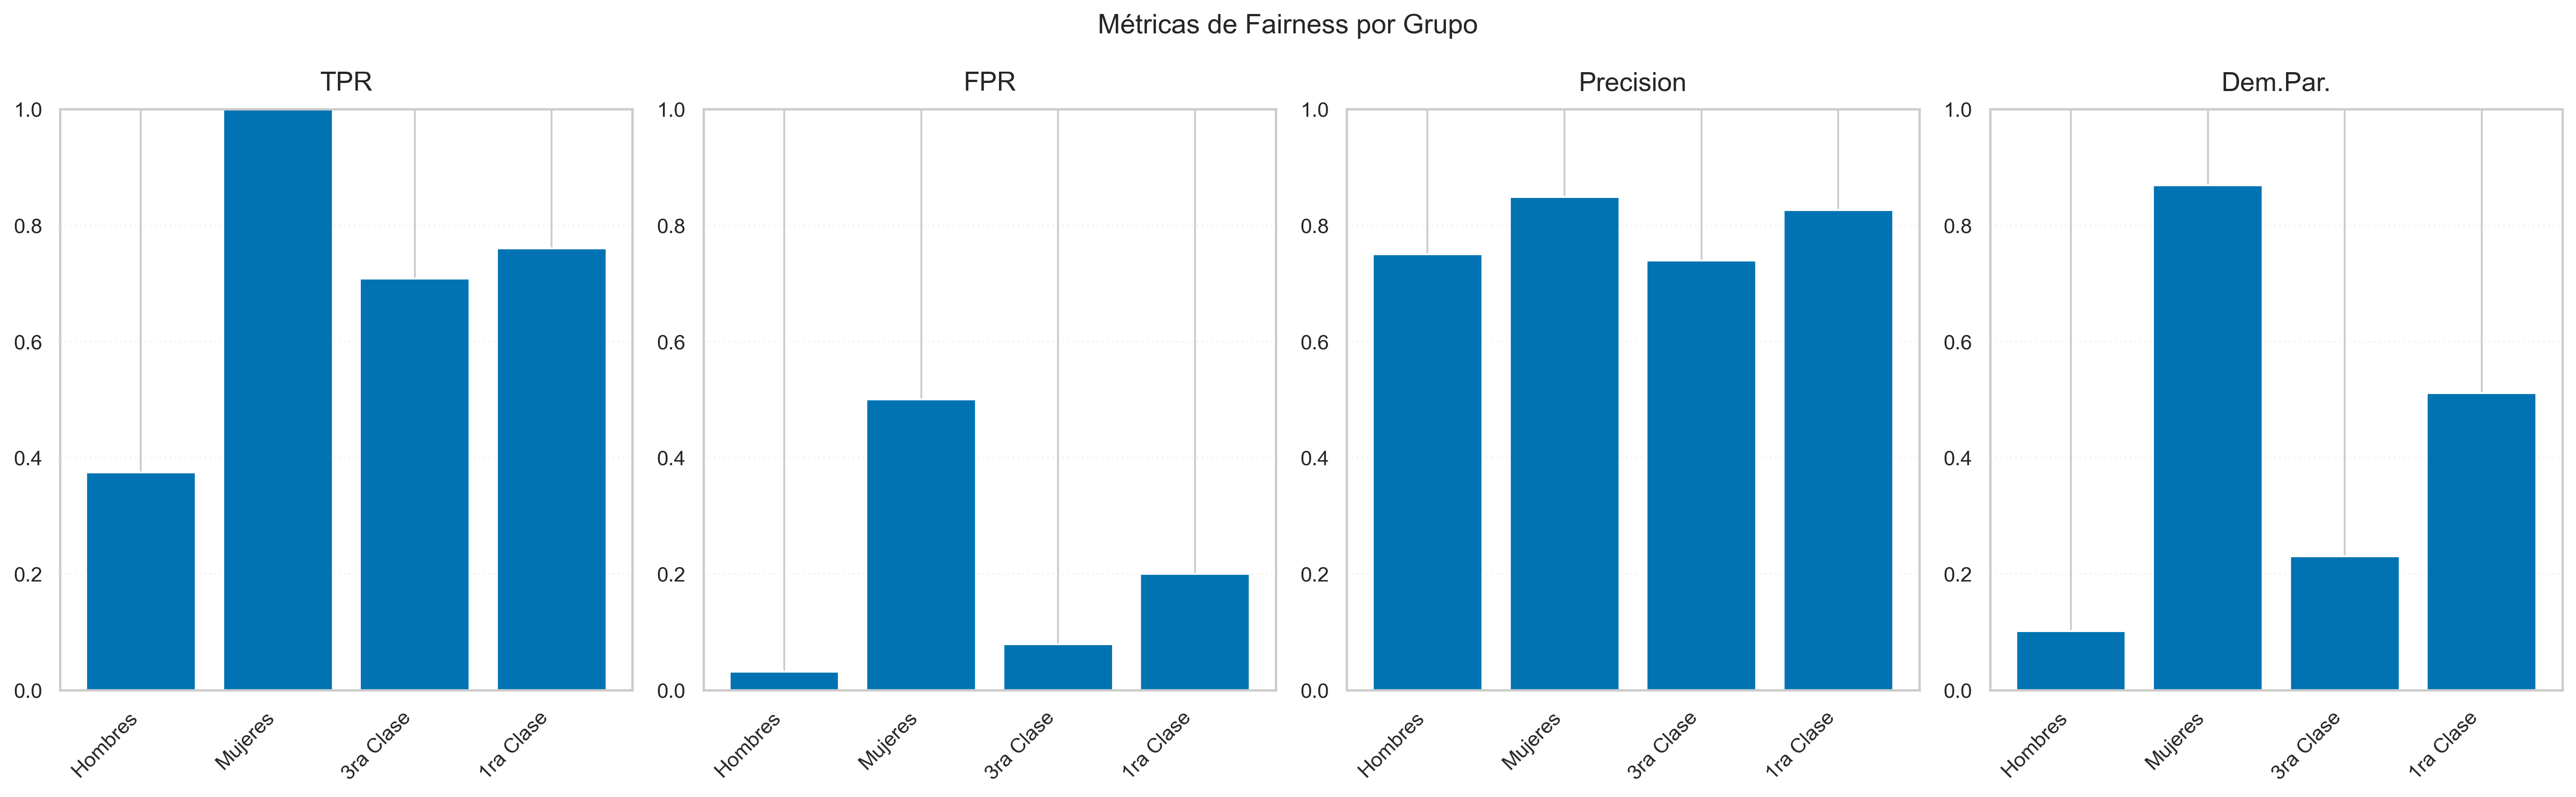

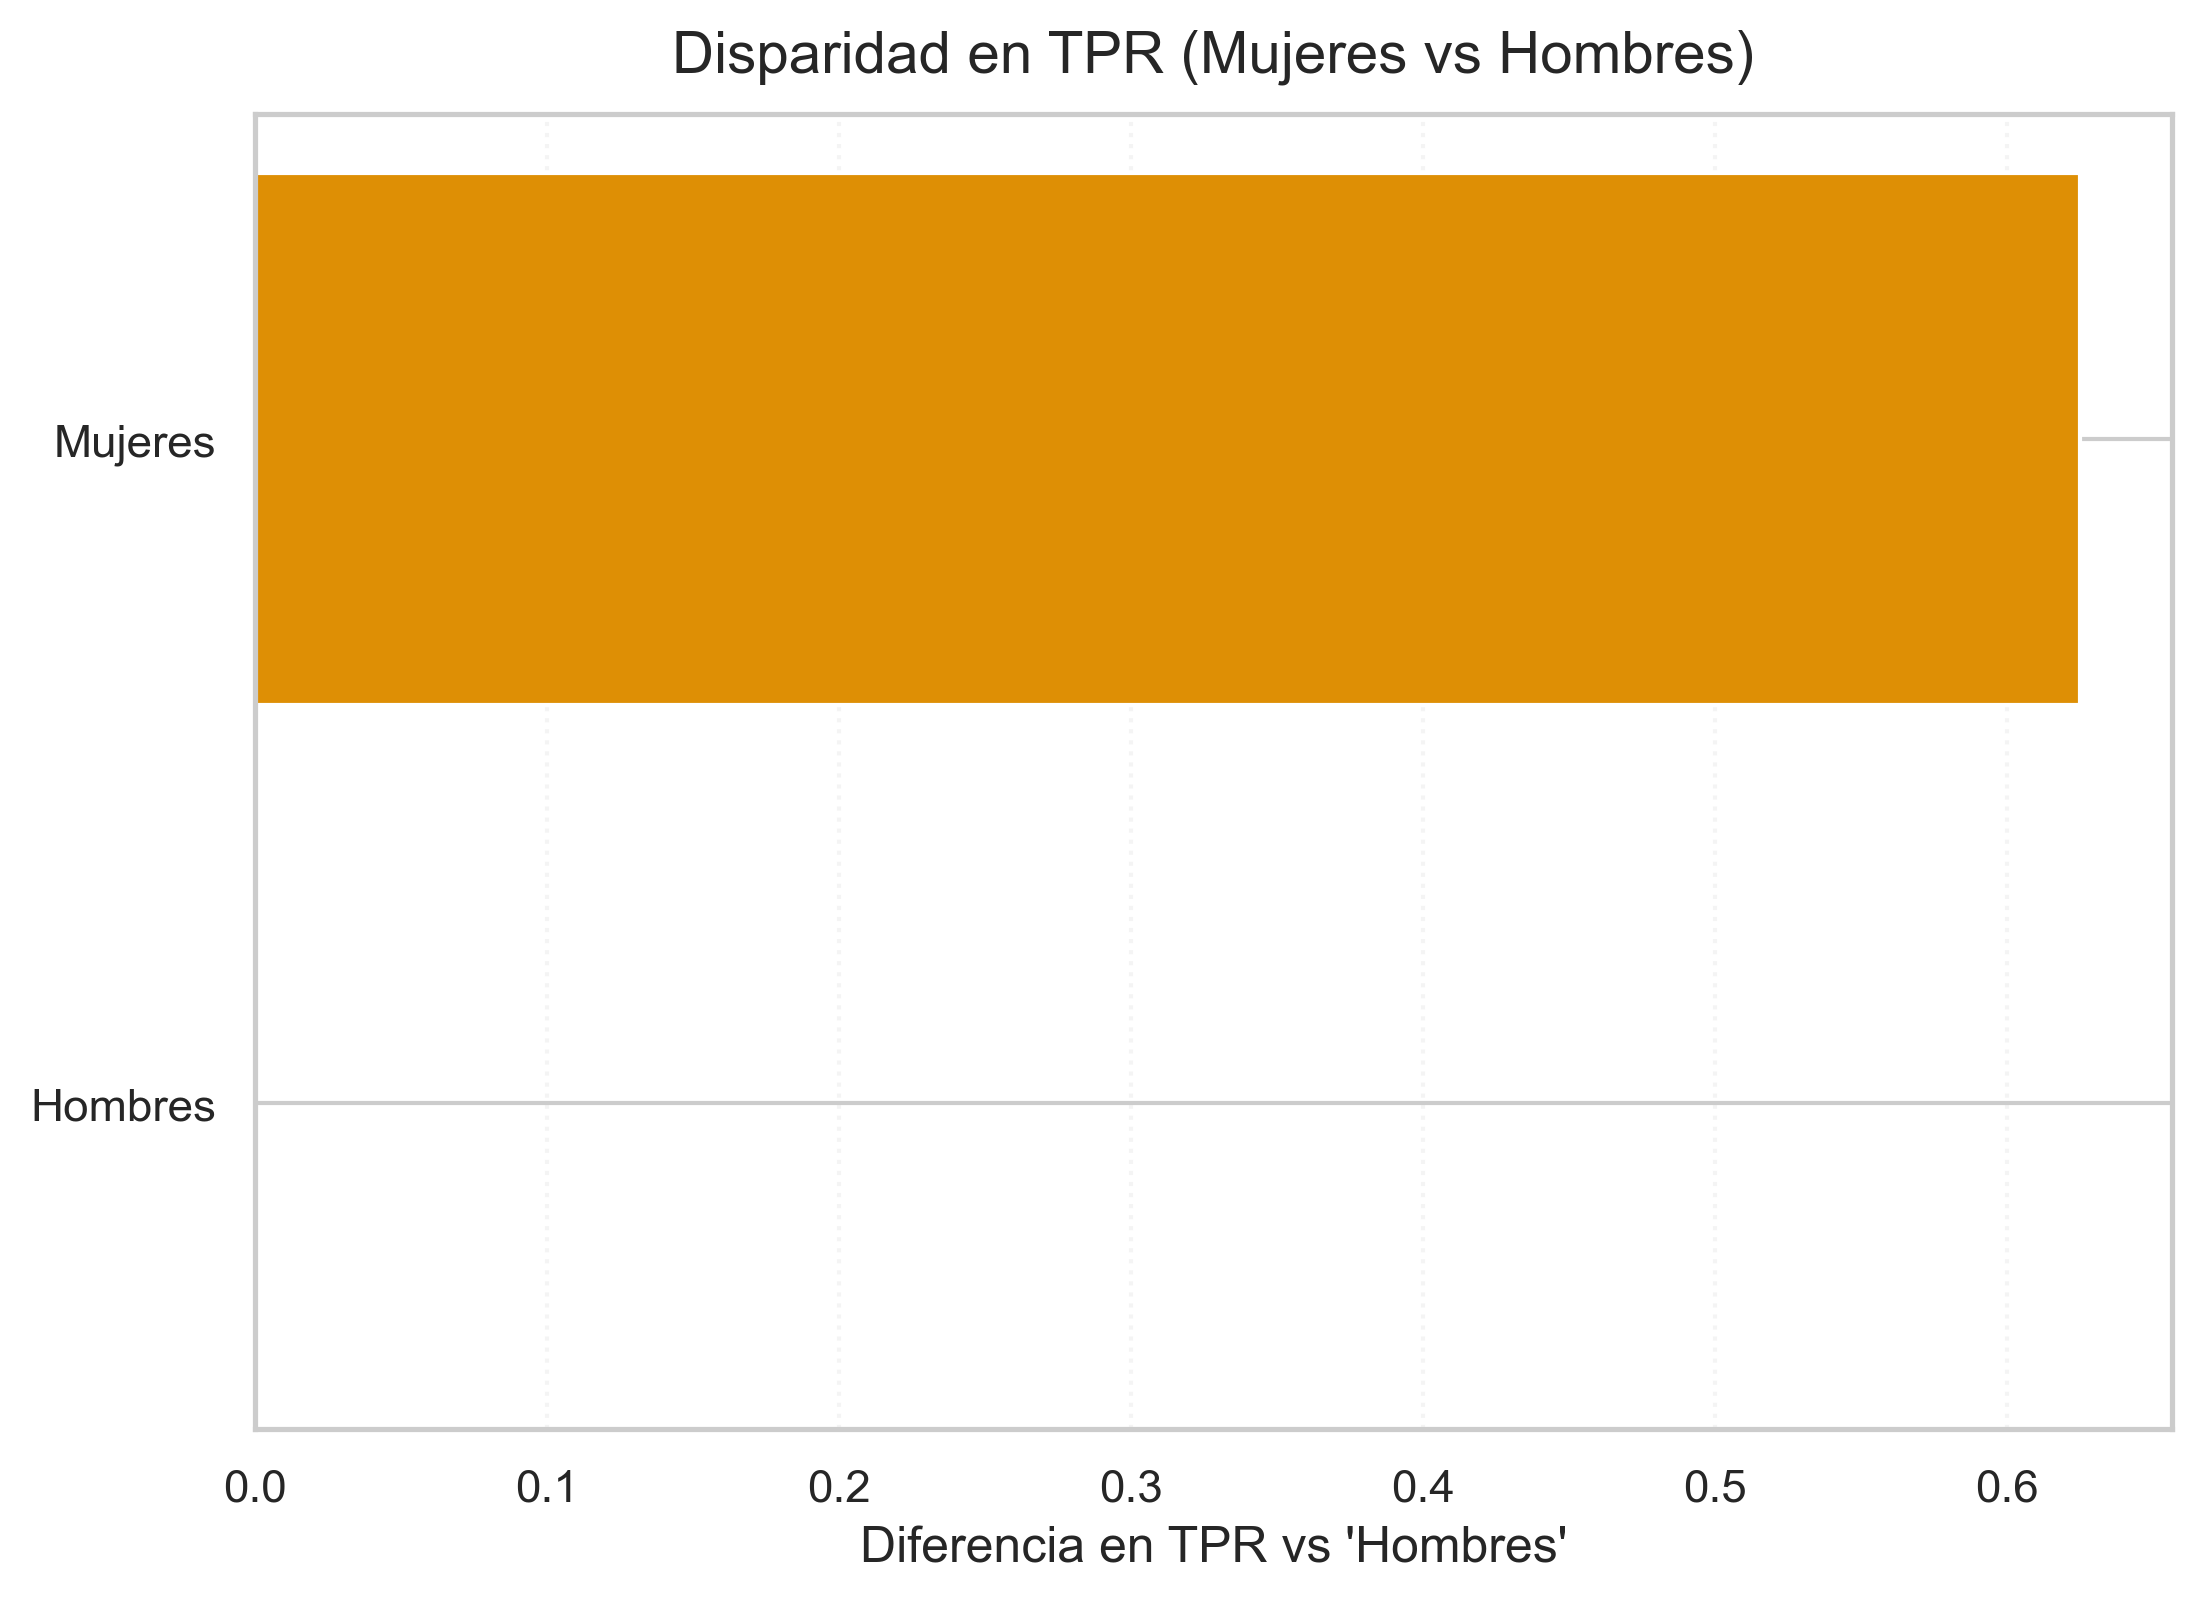

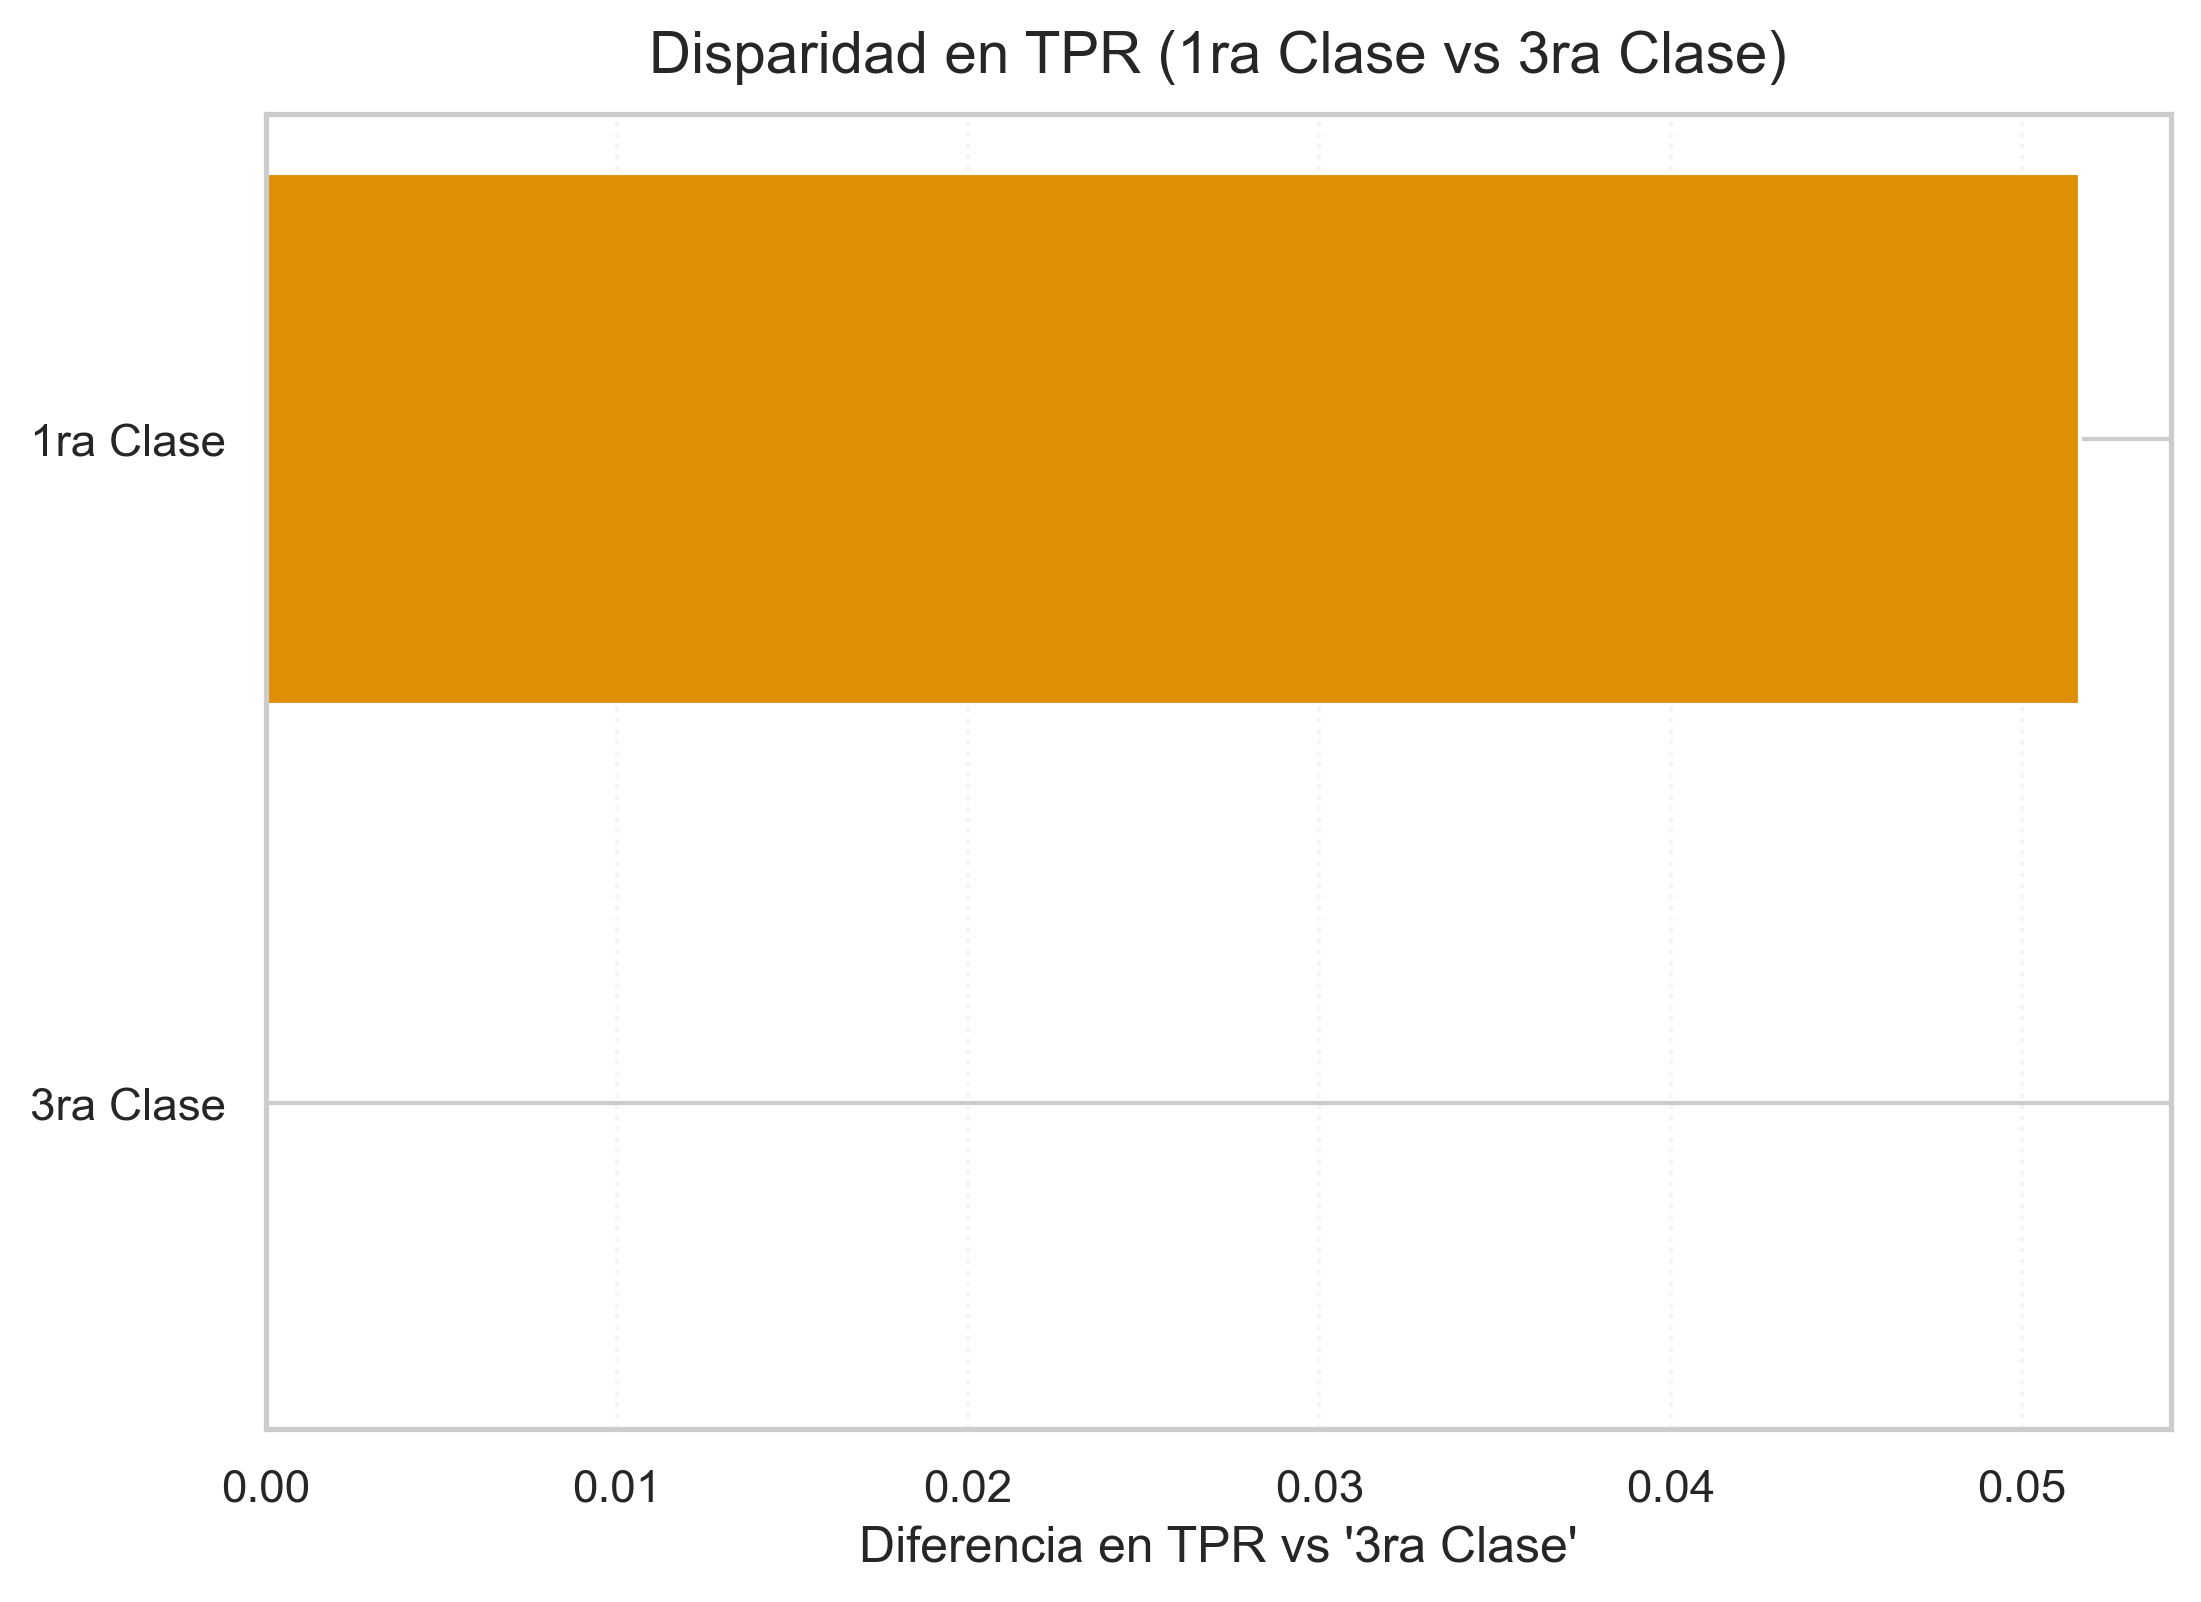

In [4]:
# Barras por métrica (todos los grupos)
fig_bars = plot_fairness_bars(
    tabla2,
    name="fairness_bars",
    title="Métricas de Fairness por Grupo",
    caption="Bar chart de TPR, FPR, Precision y Dem.Par. por grupo en test."
)
display(Image(filename=str(fig_bars)))

# Disparidad vs referencia por atributo
# Referencias razonables: 'Hombres' para sexo, '3ra Clase' para clase 
if "Hombres" in tabla2["Grupo"].values:
    disp_sex = plot_fairness_disparity(
        df=tabla2[tabla2["Grupo"].isin(["Hombres","Mujeres"])],
        metric="TPR",
        reference="Hombres",
        name="disparity_tpr_sex_ref_male",
        title="Disparidad en TPR (Mujeres vs Hombres)",
        caption="Diferencia en TPR respecto a Hombres (positivo = ventaja para Mujeres)."
    )
    display(Image(filename=str(disp_sex)))

if set(["1ra Clase","3ra Clase"]).issubset(set(tabla2["Grupo"].values)):
    disp_cls = plot_fairness_disparity(
        df=tabla2[tabla2["Grupo"].isin(["1ra Clase","3ra Clase"])],
        metric="TPR",
        reference="3ra Clase",
        name="disparity_tpr_class_ref_3rd",
        title="Disparidad en TPR (1ra Clase vs 3ra Clase)",
        caption="Diferencia en TPR respecto a 3ra Clase (positivo = ventaja para 1ra Clase)."
    )
    display(Image(filename=str(disp_cls)))

,Grupo,TPR,FPR,Precision,Dem.Par.,N
0,Sexo=Hombres & Pclass=3ra Clase,0.300,0.000,1.000,0.042,72
1,Sexo=Hombres & Pclass=1ra Clase,0.455,0.158,0.625,0.267,30
2,Sexo=Mujeres & Pclass=3ra Clase,1.000,0.429,0.700,0.714,28
3,Sexo=Mujeres & Pclass=1ra Clase,1.000,1.000,0.933,1.000,15


c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=45, ha="right")
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=45, ha="right")
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=45, ha="right")
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_x

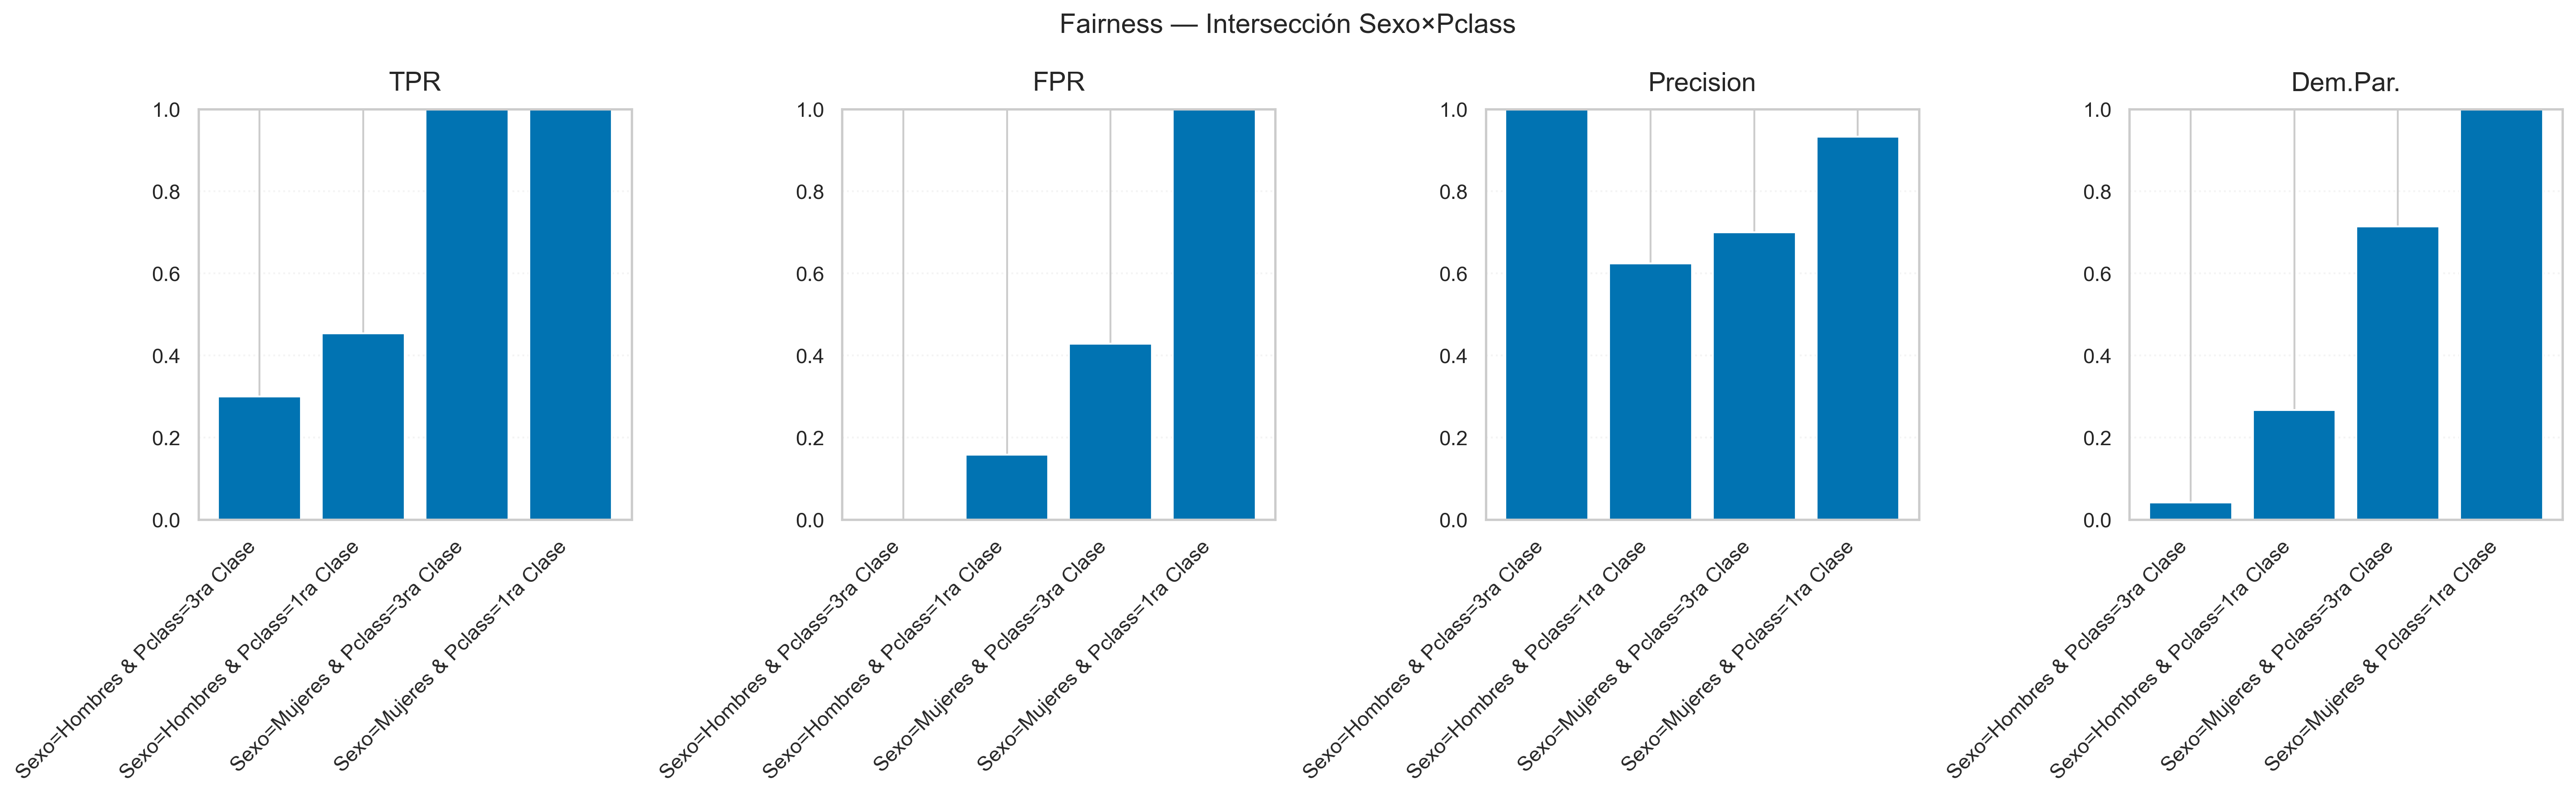

In [5]:
# Interseccional: usamos sólo 1ra y 3ra para ilustración (se puede ampliar)
if (sex is not None) and (pclass is not None):
    mask_13 = pclass.isin([1,3]).values
    df_inter = group_metrics_intersection_df(
        y_true=y_test[mask_13],
        y_pred=y_pred_test[mask_13],
        y_prob=proba_test[mask_13],
        group_a=sex[mask_13].map({"male":"Hombres","female":"Mujeres"}),
        name_a="Sexo",
        group_b=pclass[mask_13].map({1:"1ra Clase",3:"3ra Clase"}),
        name_b="Pclass"
    )
    # Guardar tabla
    path_inter = save_table(
        df_inter[["Grupo","TPR","FPR","Precision","Dem.Par.","N"]].round(3),
        name="fairness_intersection_sex_pclass",
        description="Métricas por intersección Sexo×Pclass en test."
    )
    display(df_inter[["Grupo","TPR","FPR","Precision","Dem.Par.","N"]].round(3))

    # Visual: barras de TPR por grupo interseccional
    from src.visualization import plot_bar_counts
    fig_inter = plot_fairness_bars(
        df=df_inter[["Grupo","TPR","FPR","Precision","Dem.Par."]],
        name="fairness_intersection_bars",
        title="Fairness — Intersección Sexo×Pclass",
        caption="Comparativo de TPR/FPR/Precision/Dem.Par. por intersección de grupos."
    )
    display(Image(filename=str(fig_inter)))

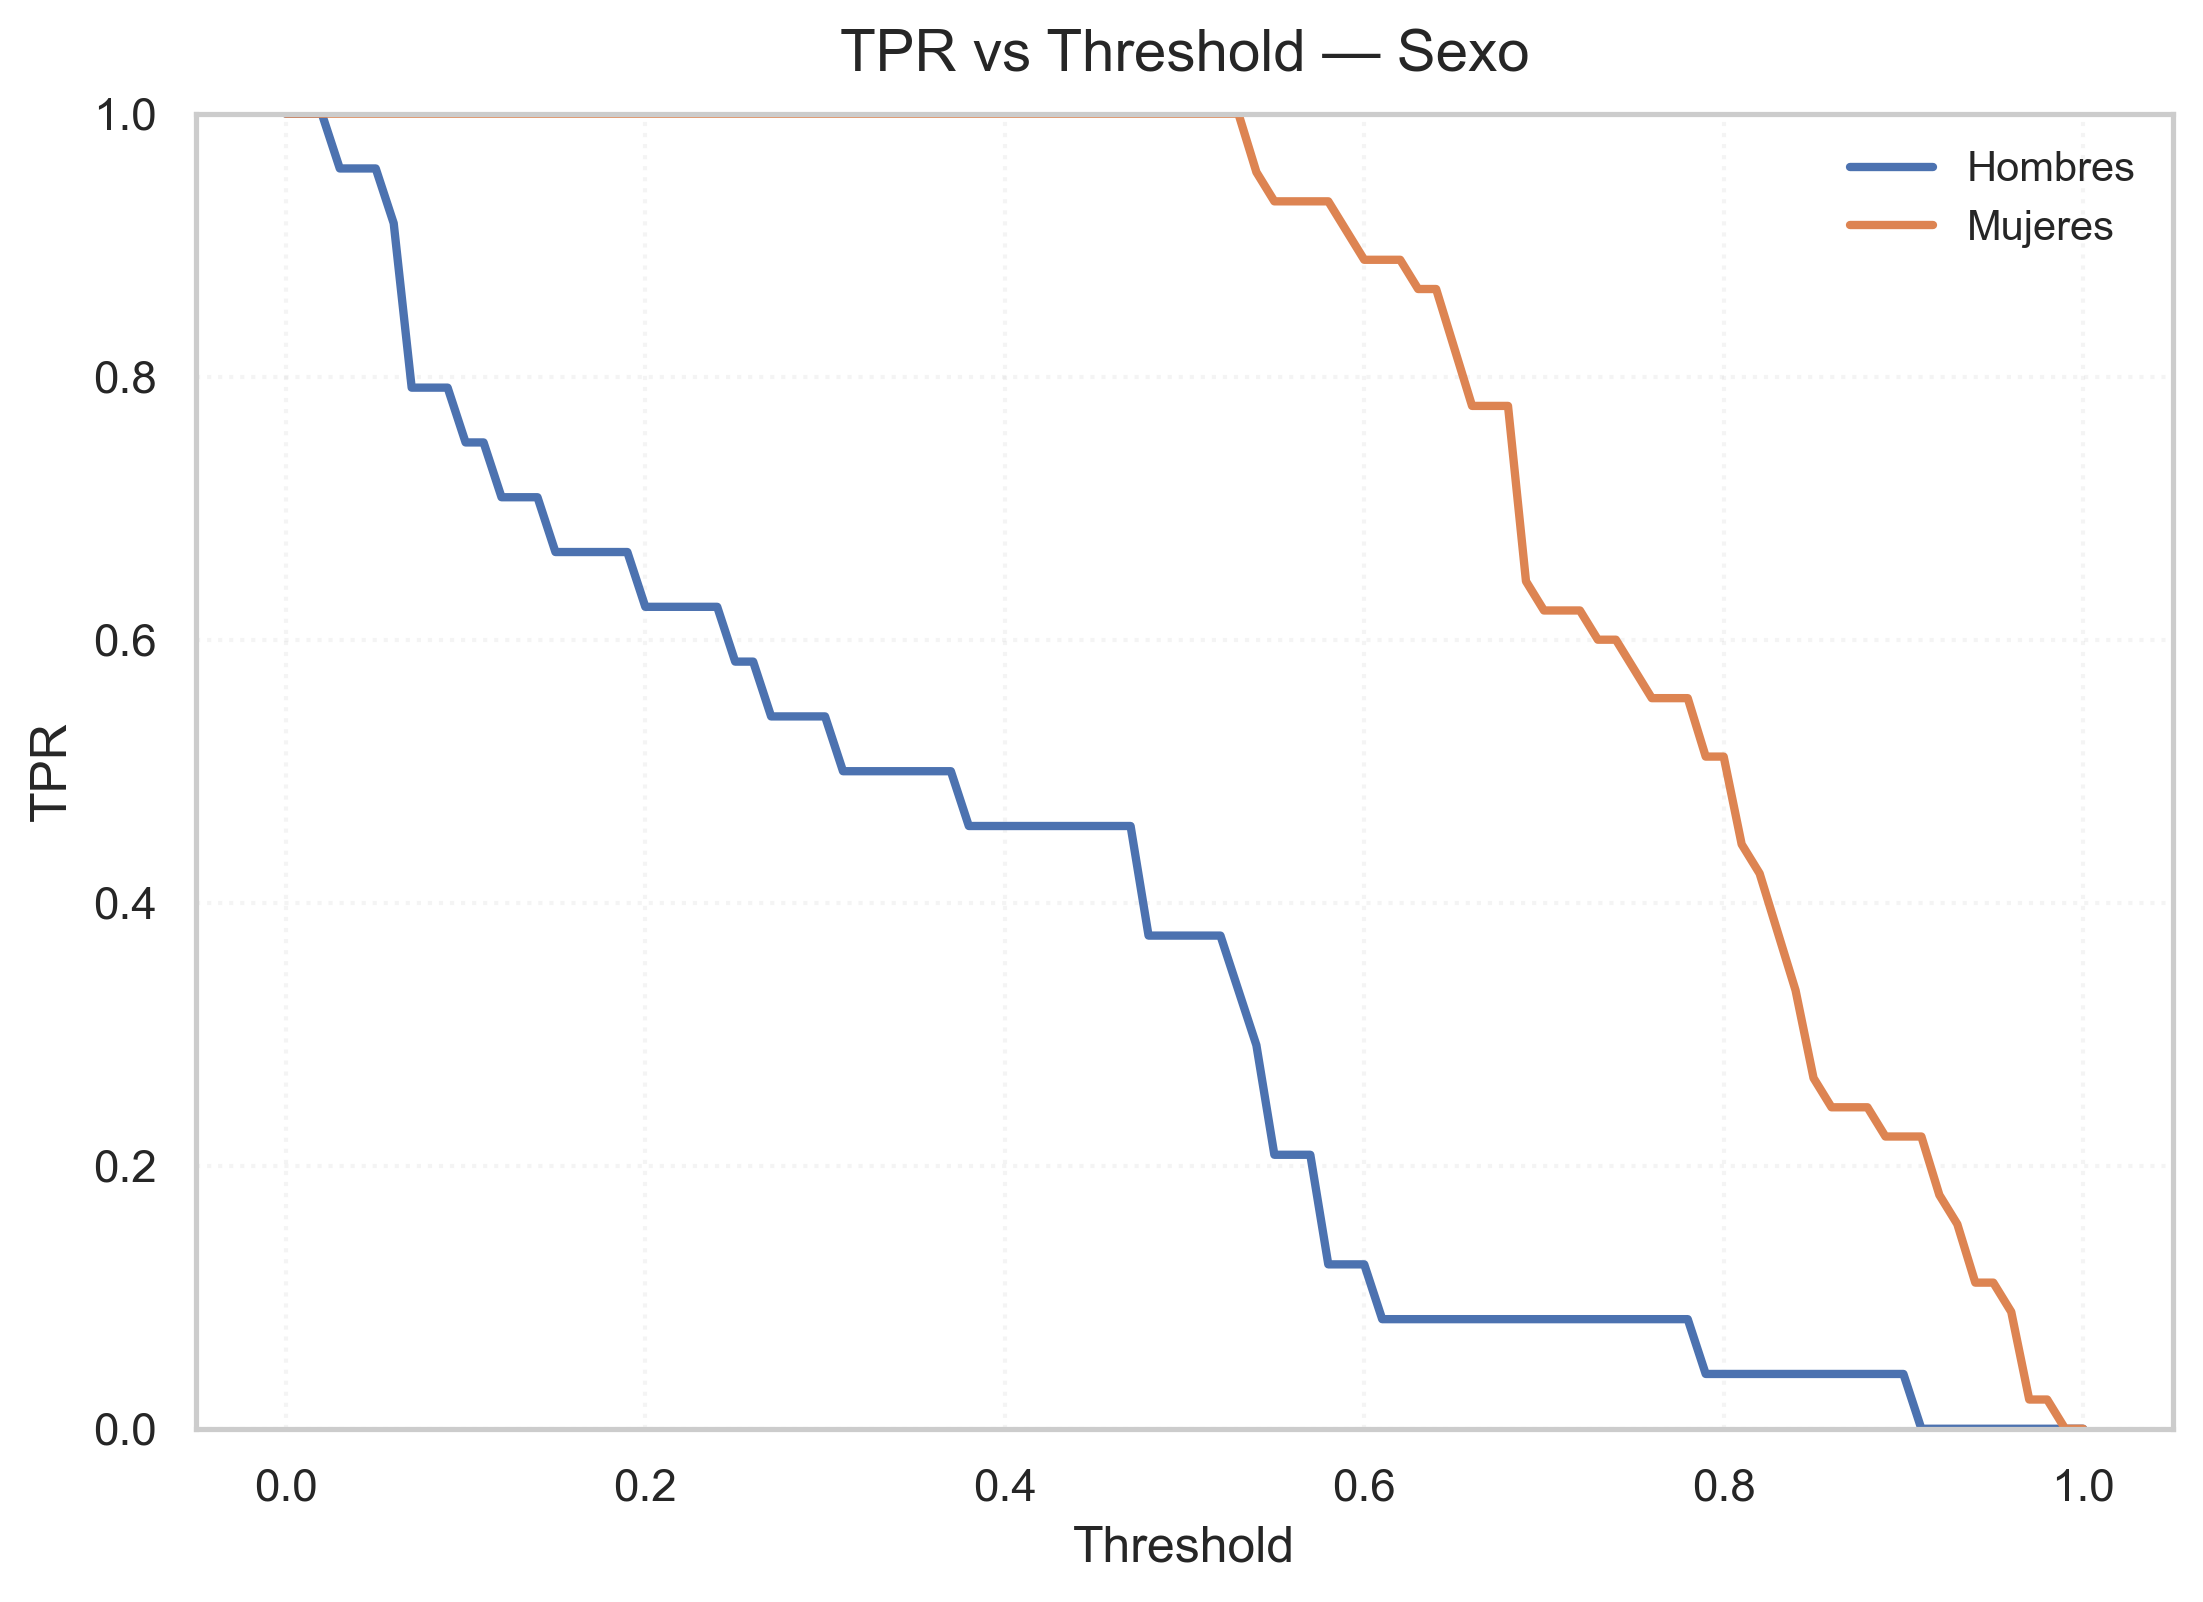

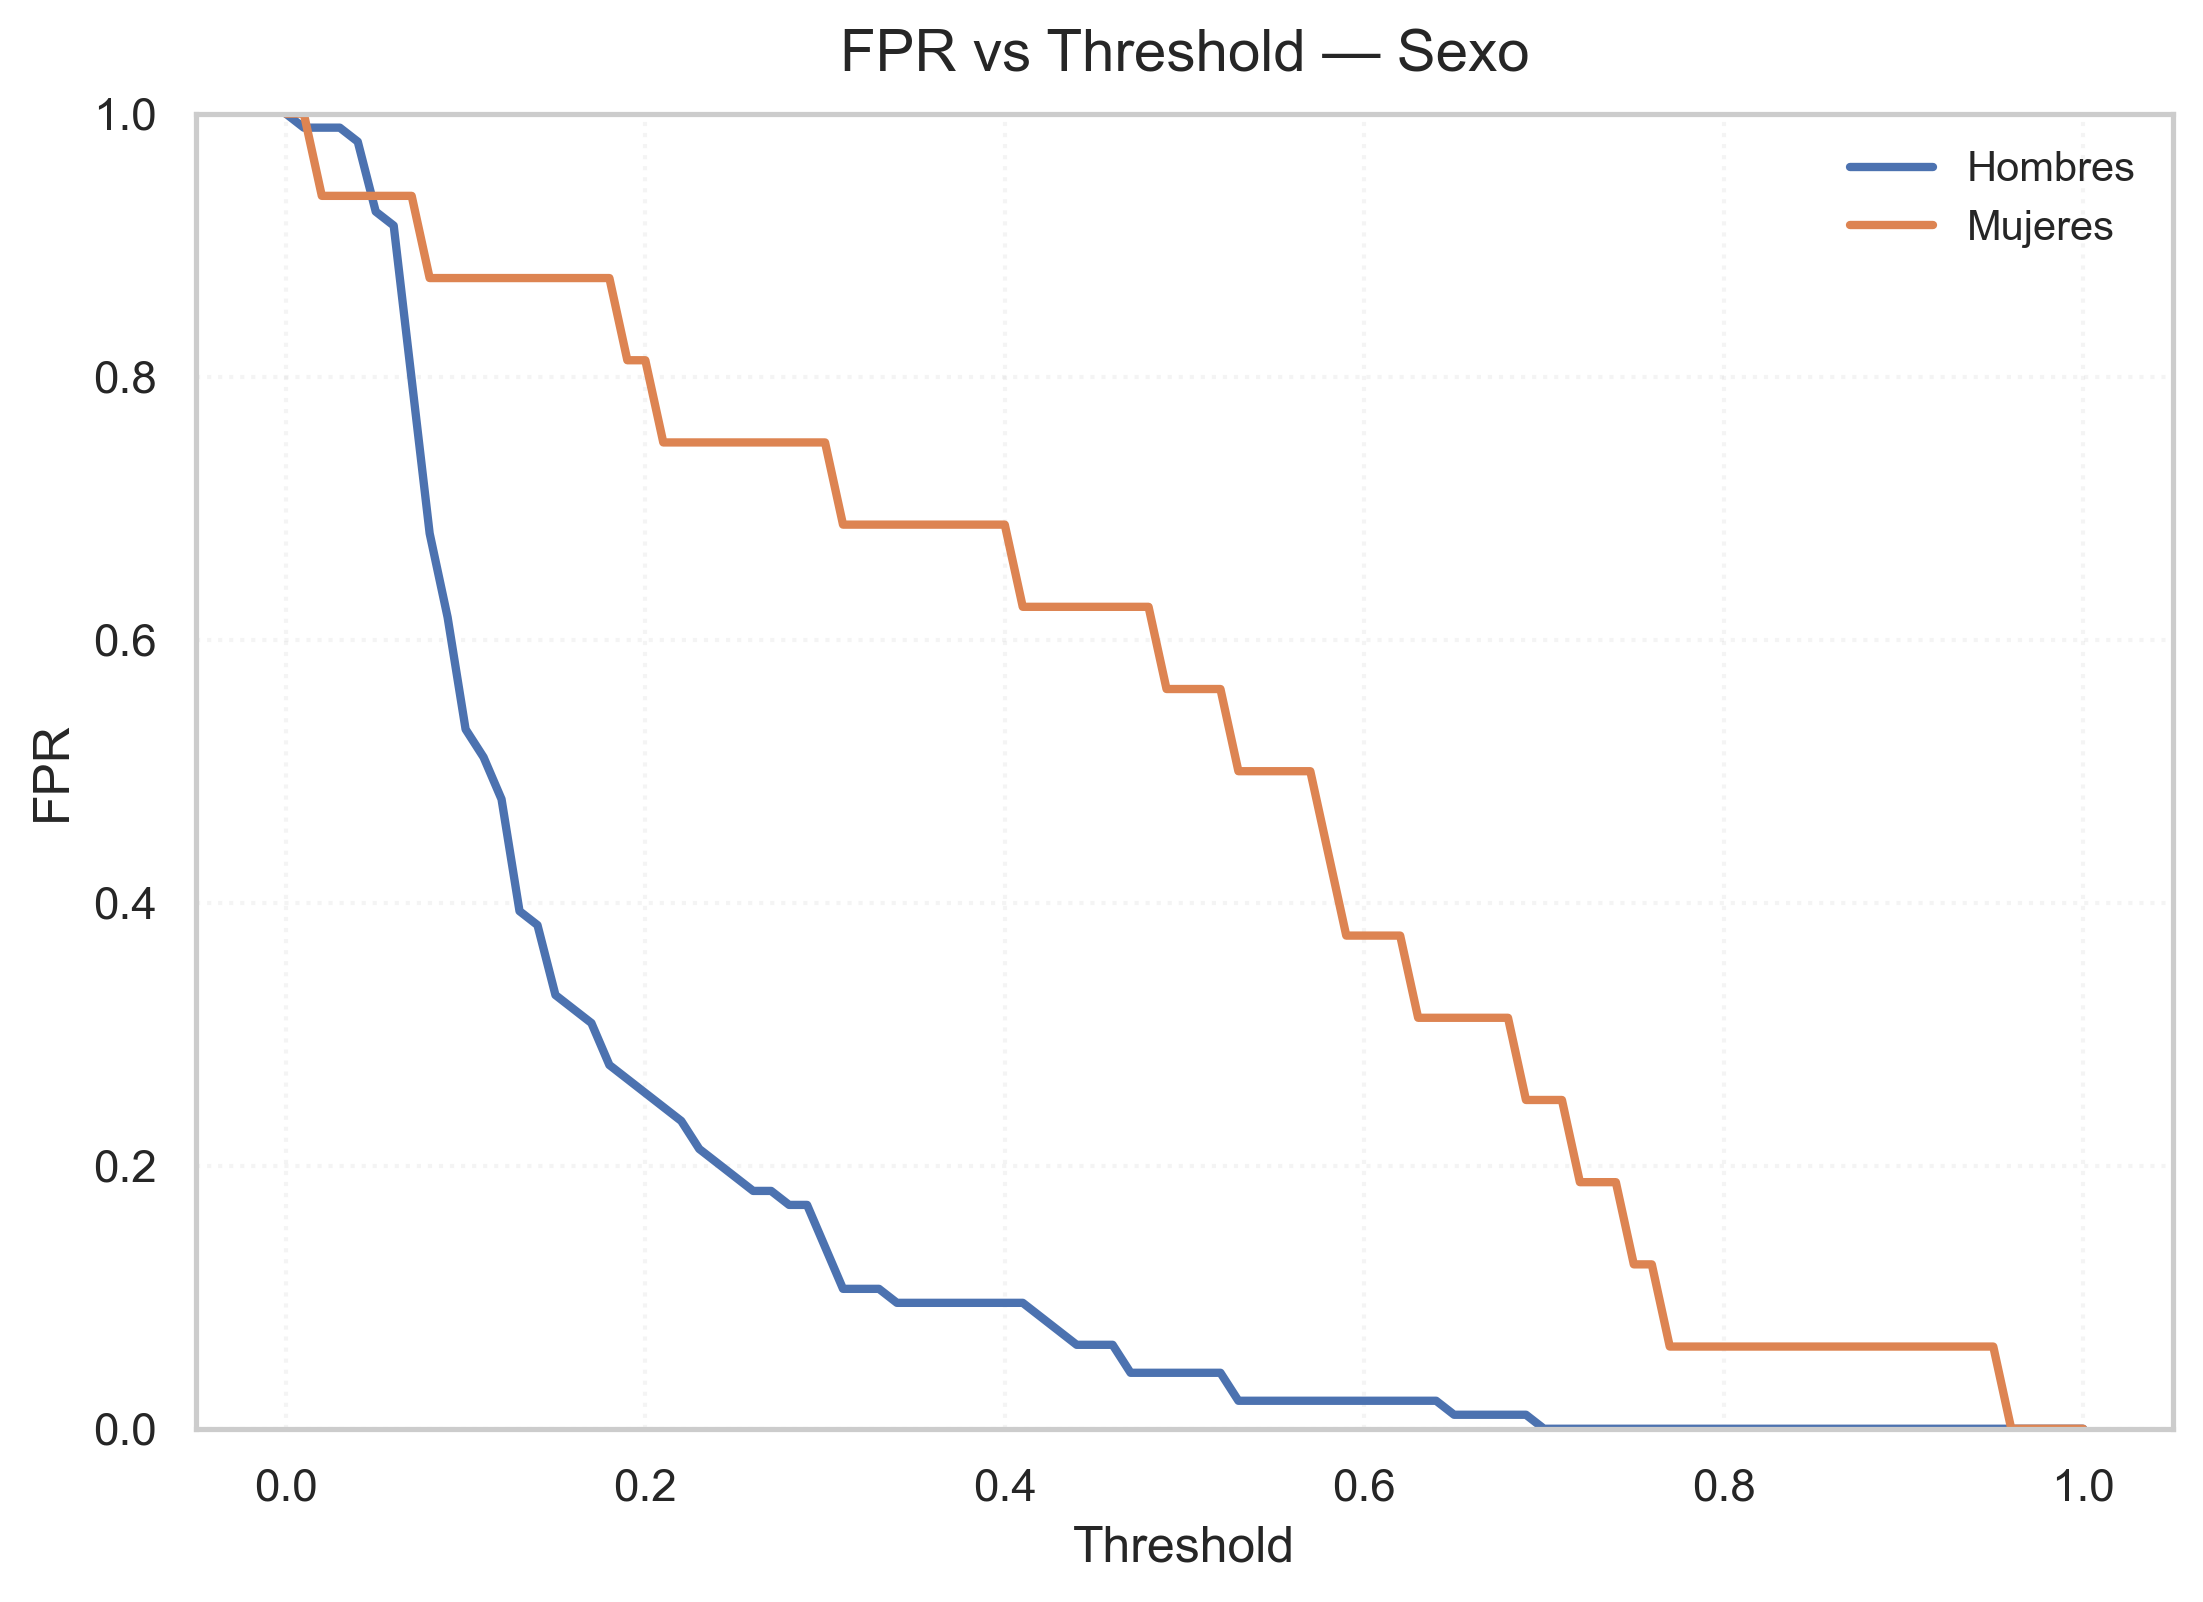

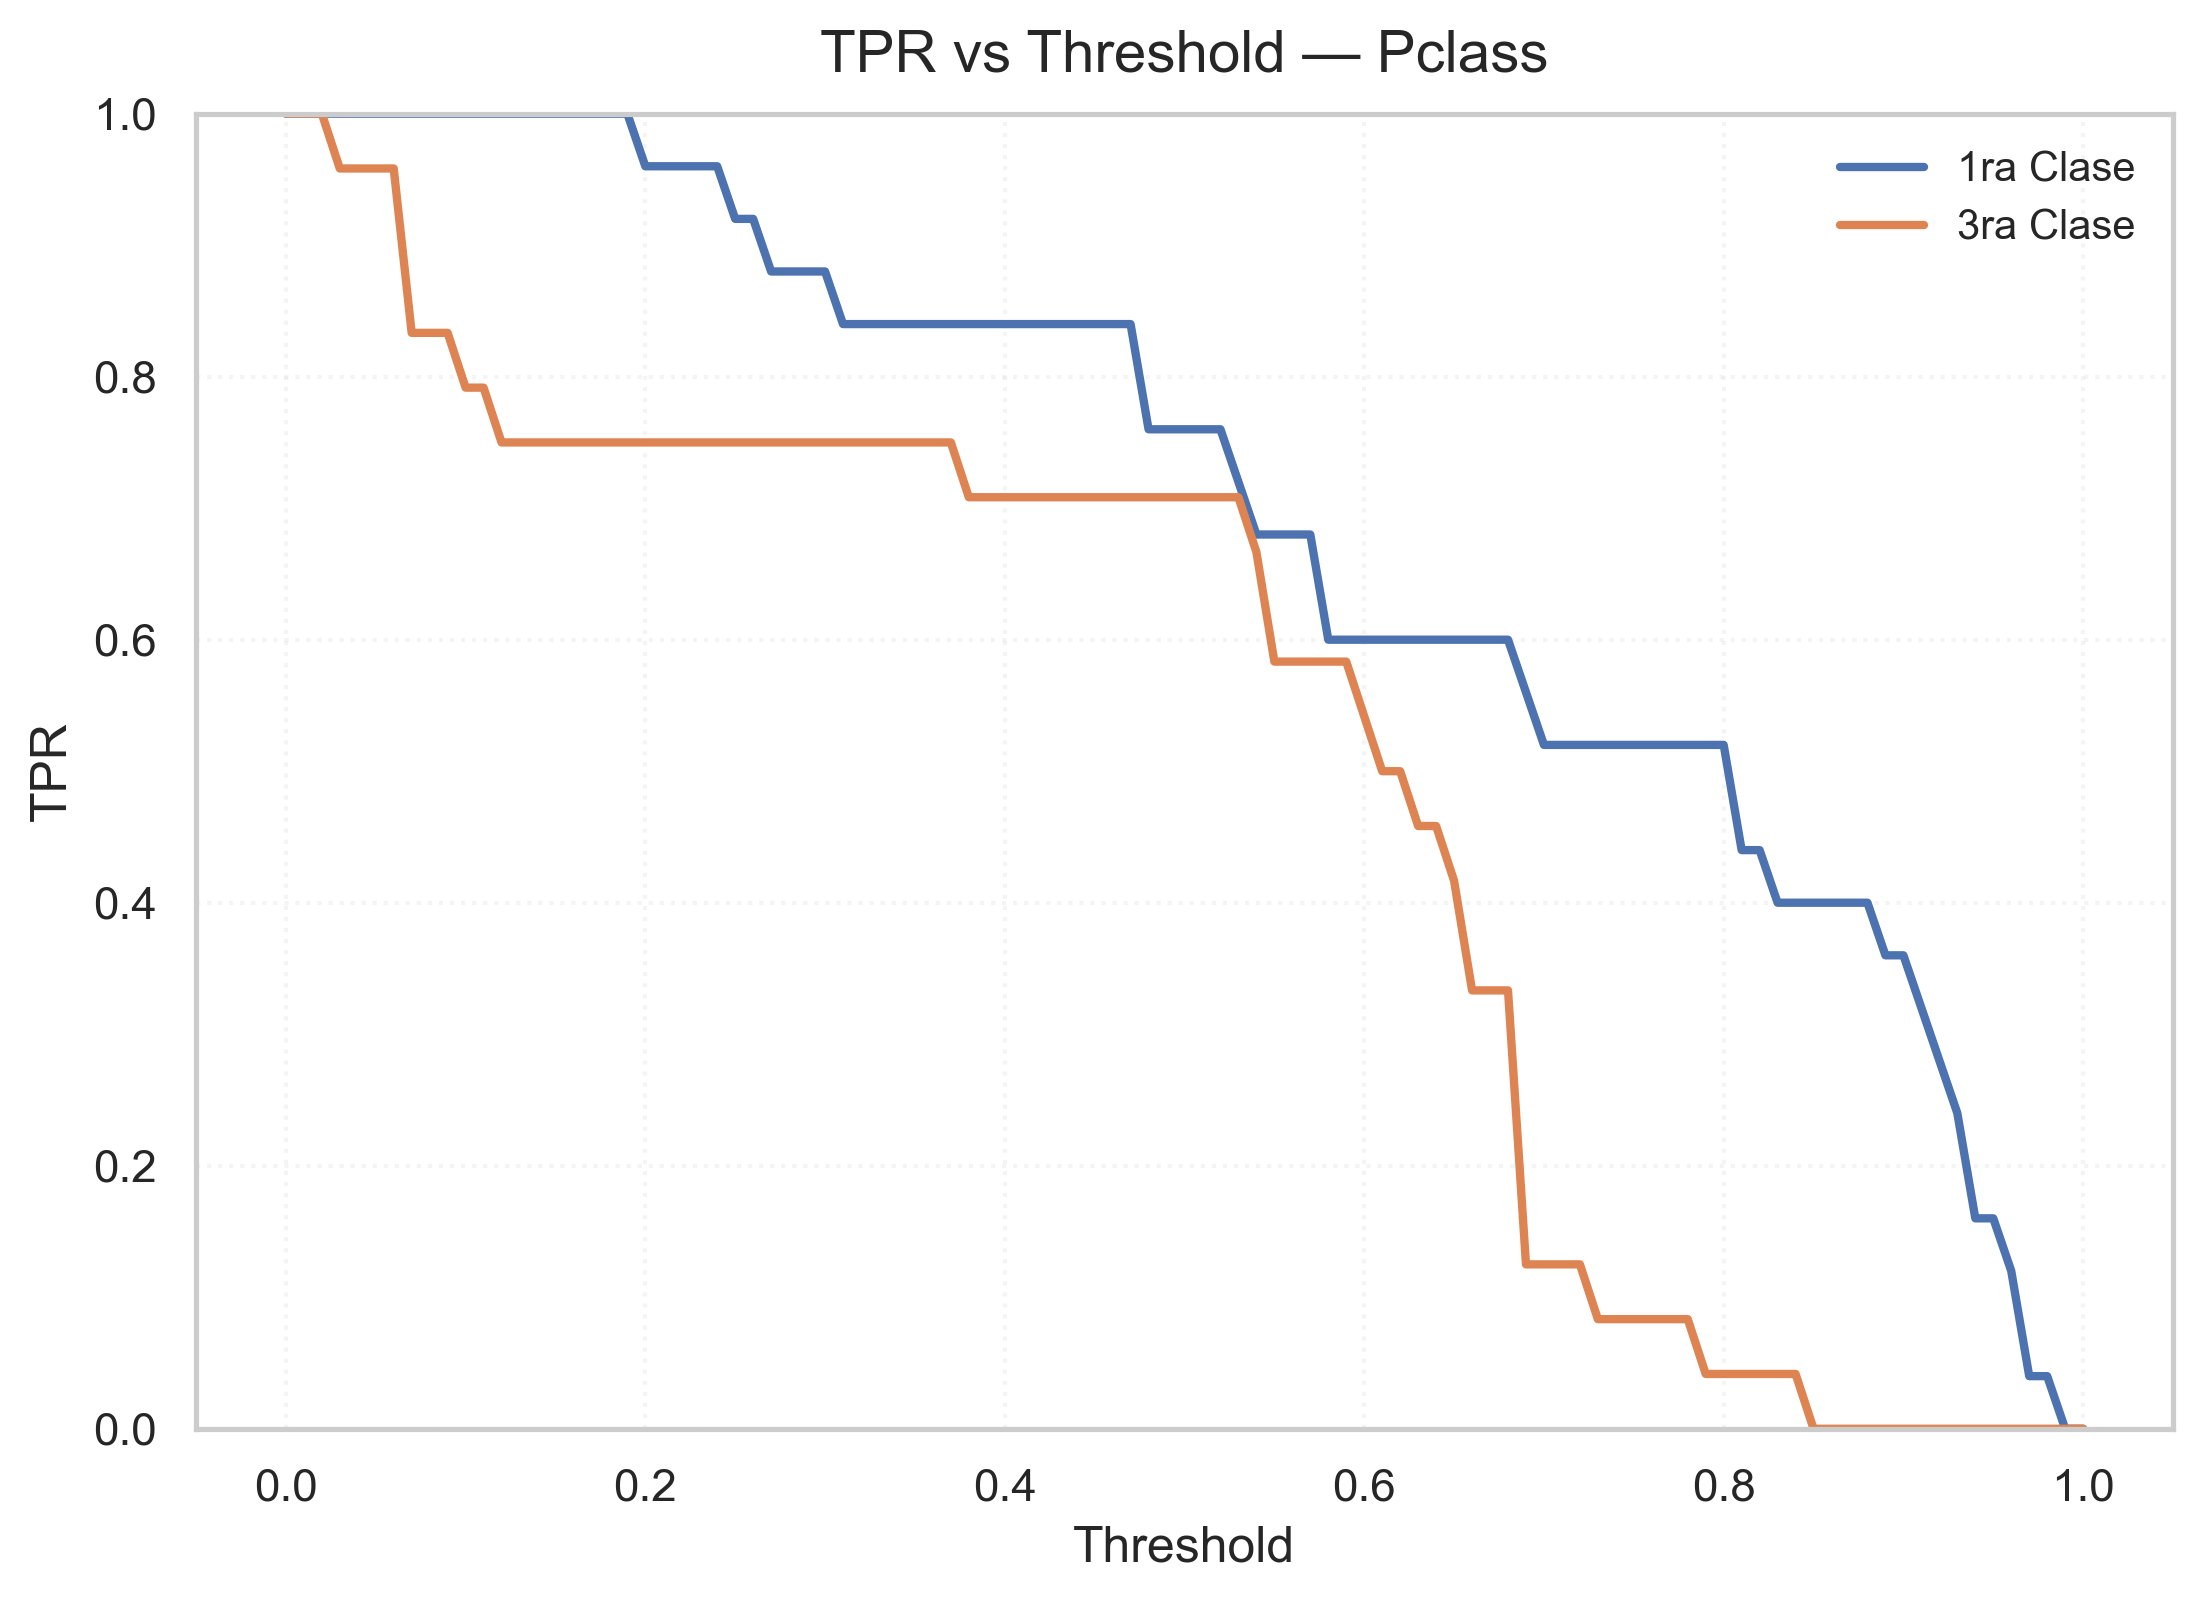

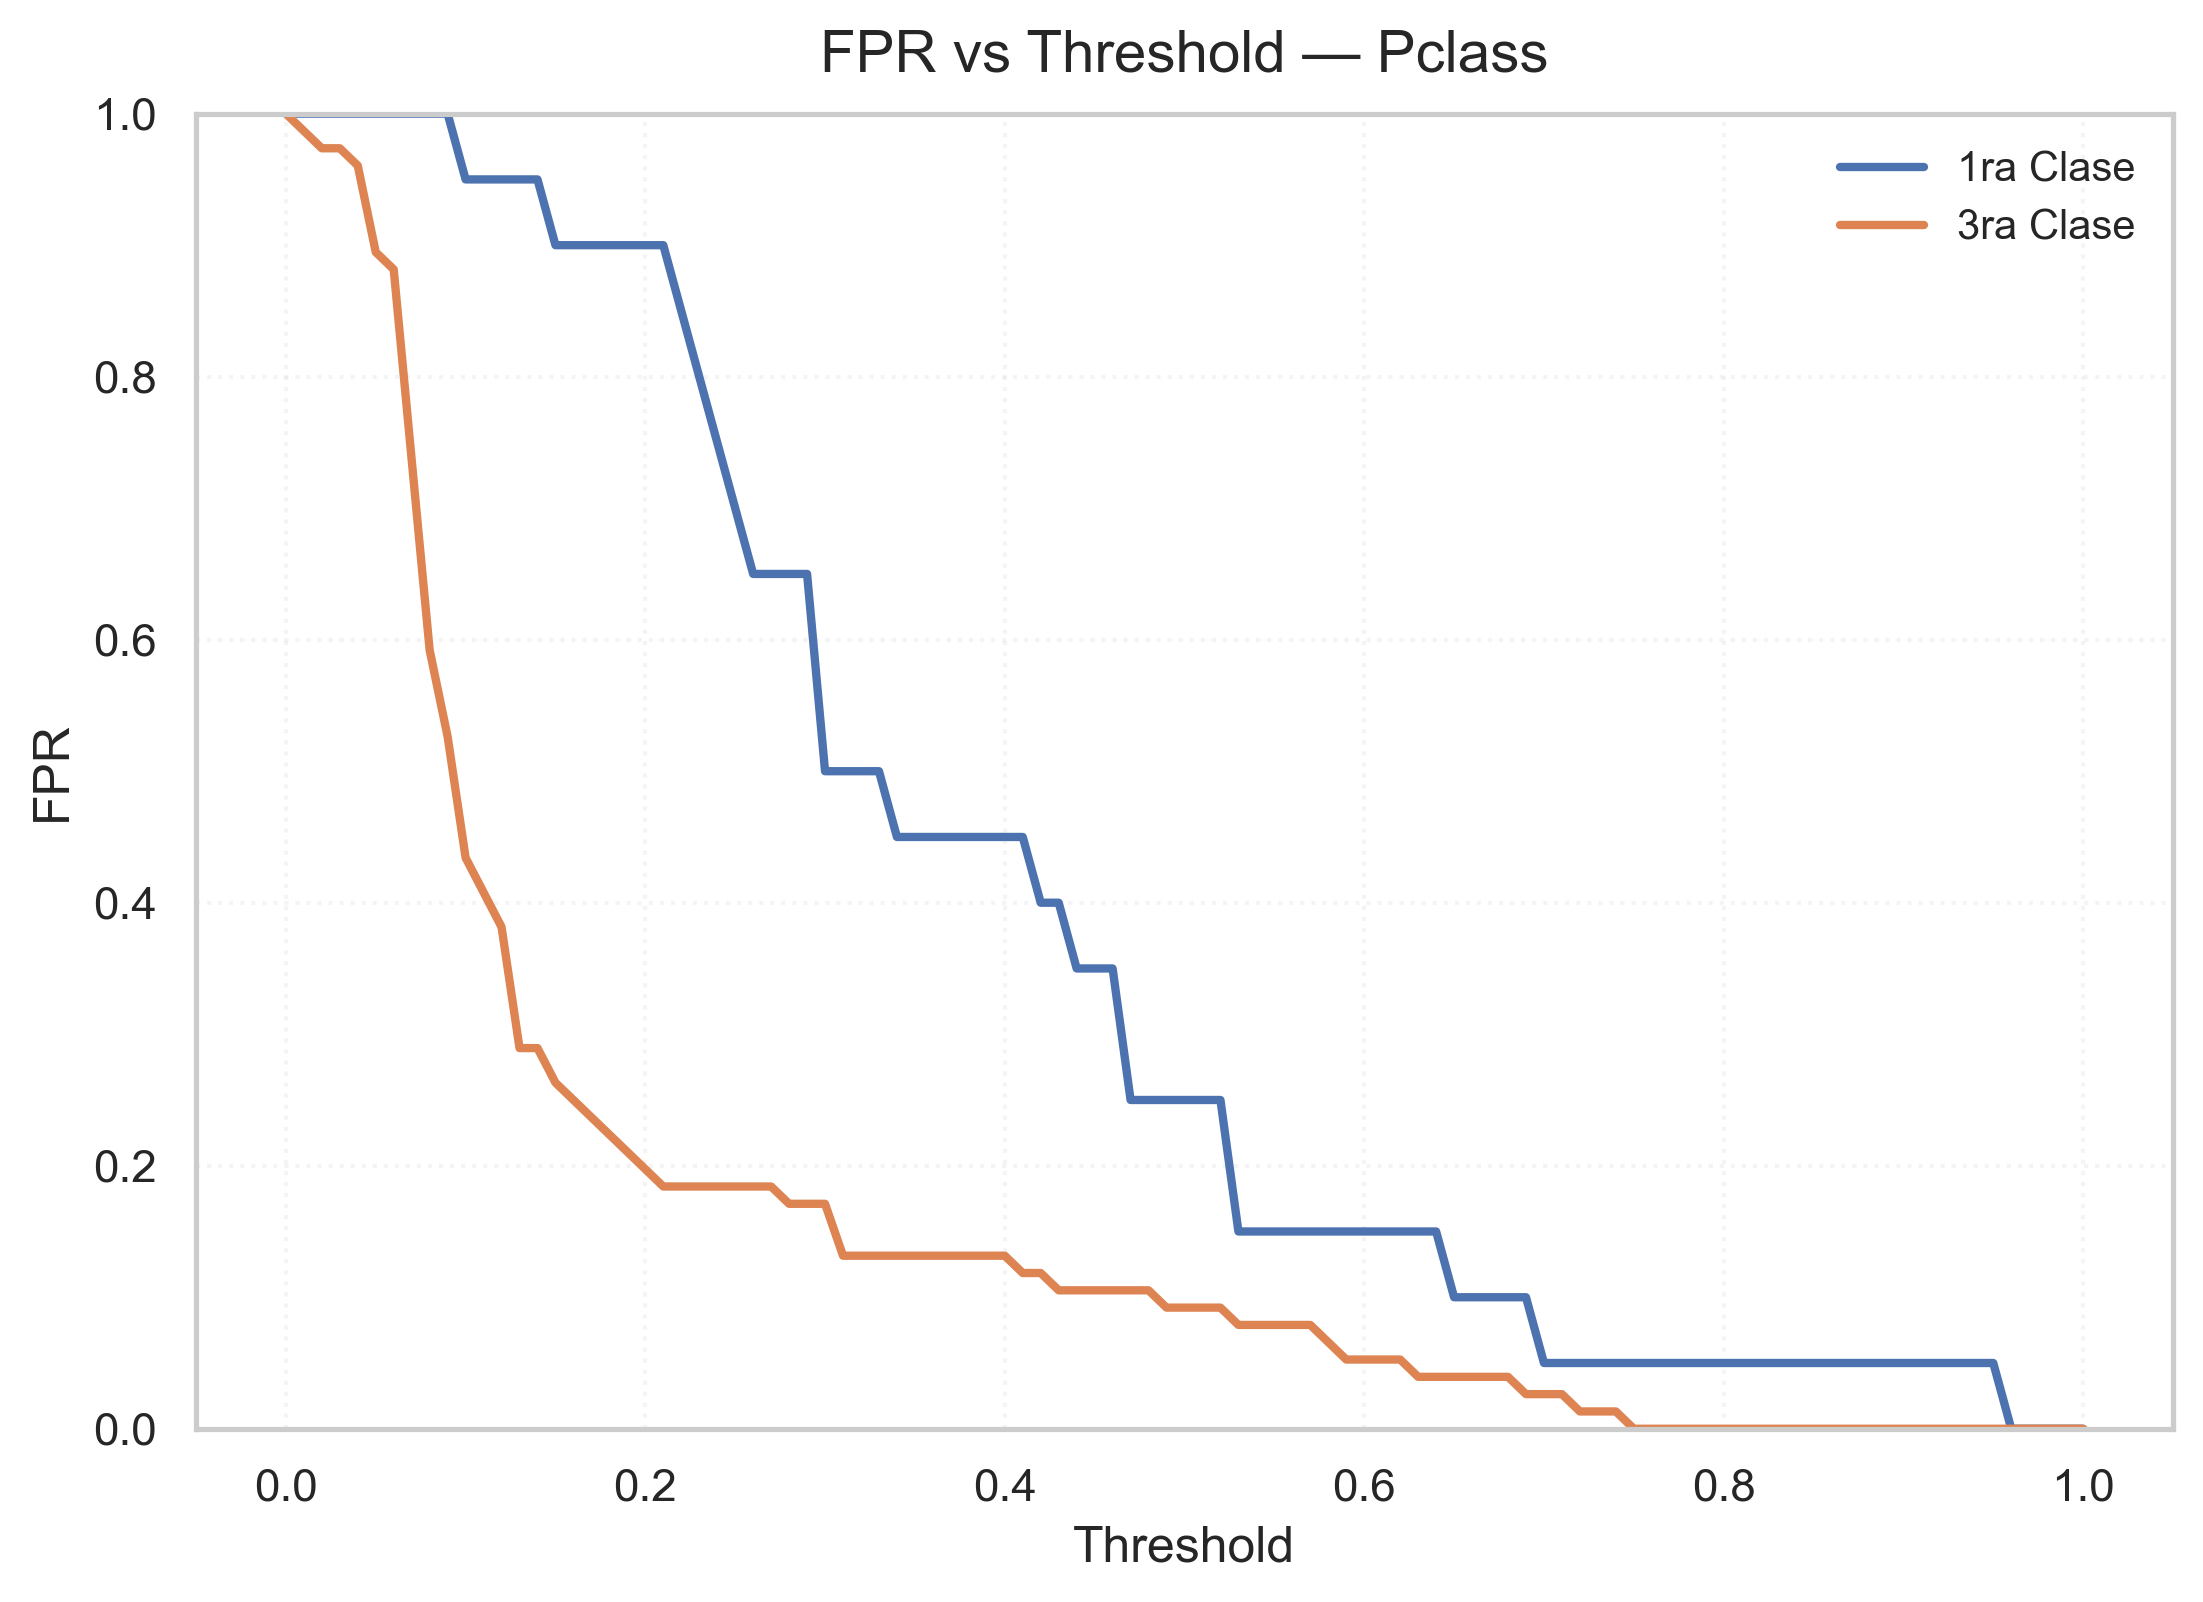

In [6]:
# Curvas threshold → {TPR, FPR} por grupo
curves_out = []

if sex is not None:
    sex_lab = sex.map({"male": "Hombres", "female": "Mujeres"}).fillna(sex.astype(str))
    thr_sex = sweep_group_thresholds(y_true=y_test, y_prob=proba_test, group=sex_lab, n=101)
    curves_out.append(("Sexo", thr_sex))

if pclass is not None:
    thr_cls = sweep_group_thresholds(y_true=y_test, y_prob=proba_test, group=pclass.map({1:"1ra Clase",2:"2da Clase",3:"3ra Clase"}), n=101)
    # nos quedamos con 1ra y 3ra para foco
    thr_cls = thr_cls[thr_cls["Grupo"].isin(["1ra Clase","3ra Clase"])]
    curves_out.append(("Pclass", thr_cls))

for name_attr, df_thr in curves_out:
    # TPR vs threshold
    fig_tpr = plot_group_threshold_tradeoff(
        df_thr[["Grupo","threshold","TPR"]],
        metric="TPR",
        name=f"thr_tradeoff_TPR_{name_attr}",
        title=f"TPR vs Threshold — {name_attr}",
        caption=f"Curvas TPR(τ) por grupo de {name_attr}. Diferencias indican trade-offs al fijar τ global."
    )
    display(Image(filename=str(fig_tpr)))

    # FPR vs threshold
    fig_fpr = plot_group_threshold_tradeoff(
        df_thr[["Grupo","threshold","FPR"]],
        metric="FPR",
        name=f"thr_tradeoff_FPR_{name_attr}",
        title=f"FPR vs Threshold — {name_attr}",
        caption=f"Curvas FPR(τ) por grupo de {name_attr}. Disparidades en FPR reflejan cargas de error asimétricas."
    )
    display(Image(filename=str(fig_fpr)))

## Análisis de Fairness
  
La comparación por **Sexo** y **Clase** muestra diferencias claras en **TPR** (tasa de verdaderos positivos), **FPR**, **Precision** y **Dem.Par.** (paridad demográfica: P(ŷ=1|grupo)).  
En general:
- **Mujeres** suelen mostrar **TPR** y **Precision** superiores y **FPR** inferior respecto a **Hombres**.
- **1ra Clase** supera a **3ra Clase** en **TPR** y **Precision**, con **FPR** menor y mayor **Dem.Par.**

**Figura Disparidades.**  
Las barras de diferencia vs. referencia (Hombres / 3ra Clase) evidencian **ventaja sistemática** para Mujeres y 1ra Clase en TPR, consistente con hallazgos del EDA y el modelado.

**Análisis interseccional (Sexo × Clase).**  
Los subgrupos **Mujeres & 1ra Clase** concentran las mejores métricas; **Hombres & 3ra Clase** los peores resultados. Los tamaños muestrales (N) confirman que estas disparidades son relevantes y no solo artefactos de baja N.

**Trade-offs identificados.**  
Las curvas **TPR(τ)** y **FPR(τ)** por grupo muestran que un **único umbral global (τ=0.525)** no optimiza simultáneamente todos los grupos:  
- Subir **τ** reduce **FPR** pero sacrifica **TPR**, afectando más a grupos con puntajes base más bajos (p.ej., Hombres o 3ra Clase).  
- Posibles mitigaciones: **ajuste de umbral por grupo** (si es legal/ético en el contexto), **recalibración** por grupo, **reponderación** durante el entrenamiento o **post-procesamiento** (p.ej., equalized odds).

## Hipótesis: Evidencia y Matices

**H1 — Títulos de alto estatus ⇒ mayor supervivencia.**  
- **Evidencia:** Importancias y SHAP destacan **Title** (p.ej., *Mrs/Master/Officer*), y fairness muestra ventajas alineadas con estatus (vía correlatos como **Pclass** y **HasCabin**).  
- **Grado de soporte:** **Alto**.  
- **Matices:** El efecto co-varía con **Sexo** y **Pclass**; títulos como *Mr* penalizan notablemente, mientras *Master/Mrs/Officer* empujan a favor.

**H2 — Familias pequeñas (2–4) ⇒ mayor supervivencia.**  
- **Evidencia:** Señales en **FamilySize/SibSp/IsAlone** y patrones no lineales resaltados por RF/SVM; en fairness, los subgrupos con **FamilySize** intermedio suelen mejorar TPR/Precision.  
- **Grado de soporte:** **Medio–Alto**.  
- **Matices:** Curvatura clara: solitarios y familias grandes rinden peor; interacción con **Sexo** y **Clase**.

**H3 — Tarifa más alta intra-clase ⇒ mayor supervivencia.**  
- **Evidencia:** **Fare/Fare_log/FarePerPerson** aparecen consistentemente en el top; en análisis interseccional, **1ra vs 3ra** muestran brechas amplias y, dentro de clase, tarifas altas desplazan la probabilidad a favor.  
- **Grado de soporte:** **Alto**.  
- **Matices:** El efecto de **Fare** depende de **Pclass**; dentro de 3ra clase, tarifas relativamente altas no siempre compensan señales negativas (p.ej., *Sex_male*, *Title_Mr*).

## Conclusiones

El análisis de fairness revela disparidades claras en el desempeño del modelo, que reflejan tanto sesgos algorítmicos como los patrones sociales de la época del Titanic:

- **Sexo:** El modelo distingue fuertemente entre hombres y mujeres. Las mujeres alcanzan un TPR cercano al 100% y un alto nivel de paridad demográfica, mientras que los hombres apenas llegan a un TPR de 37%. Esto replica la **política de “mujeres y niños primero”**, donde la supervivencia femenina fue mucho más alta. Sin embargo, también genera un FPR elevado en mujeres, mostrando que el modelo tiende a clasificarlas en exceso como sobrevivientes.

- **Clase social (Pclass):** Los pasajeros de 1ª clase gozan de un TPR superior al de 3ª clase, aunque a costa de un FPR más alto. Esta disparidad refleja cómo el **estatus socioeconómico influyó históricamente en el acceso a los botes salvavidas**, con mayores oportunidades de supervivencia para la élite.

- **Interseccionalidad (Sexo×Clase):** Los extremos se observan en mujeres de 1ª clase (TPR=1, FPR=1) y hombres de 3ª clase (TPR=0.30, FPR=0). Estos resultados sintetizan la **doble ventaja** de ser mujer y de clase alta, frente a la **doble desventaja** de ser hombre y de clase baja. Es una representación algorítmica de las desigualdades de la época.

- **Trade-offs de umbral:** Los análisis de TPR/FPR vs threshold confirman que los beneficios en sensibilidad (recuperar más sobrevivientes) no se reparten equitativamente. Ajustar el umbral de forma global no elimina las diferencias, y un ajuste diferenciado por grupo (Equal Opportunity) sería necesario para balancear las métricas.

### Síntesis
En conjunto, los resultados muestran cómo un modelo entrenado en este contexto reproduce los patrones de discriminación histórica: **género y clase social definían las probabilidades de supervivencia**. El ejercicio evidencia que los algoritmos no son neutrales, sino espejos de los datos en los que se entrenan. Este caso concreto permite ilustrar cómo la inequidad histórica se traduce en disparidades algorítmicas, reforzando la necesidad de enfoques de fairness que consideren tanto las métricas técnicas como el contexto social.